In [2]:
import numpy as np
import itertools

np.set_printoptions(suppress=True) # to suppress scientific notation while printing arrays

### Create Data
Create a data which is supposed to represent a timeseries prediction problem. The data has 6 columns and 1000 columns. The first five columns are supposed to be input and the last column is supposed to be output.

In [36]:
rows = 2000
cols = 6
data = np.arange(int(rows*cols)).reshape(-1,rows).transpose()
print(data[0:20])  
print('\n {} \n'.format(data.shape))
print(data[-20:])

[[    0  2000  4000  6000  8000 10000]
 [    1  2001  4001  6001  8001 10001]
 [    2  2002  4002  6002  8002 10002]
 [    3  2003  4003  6003  8003 10003]
 [    4  2004  4004  6004  8004 10004]
 [    5  2005  4005  6005  8005 10005]
 [    6  2006  4006  6006  8006 10006]
 [    7  2007  4007  6007  8007 10007]
 [    8  2008  4008  6008  8008 10008]
 [    9  2009  4009  6009  8009 10009]
 [   10  2010  4010  6010  8010 10010]
 [   11  2011  4011  6011  8011 10011]
 [   12  2012  4012  6012  8012 10012]
 [   13  2013  4013  6013  8013 10013]
 [   14  2014  4014  6014  8014 10014]
 [   15  2015  4015  6015  8015 10015]
 [   16  2016  4016  6016  8016 10016]
 [   17  2017  4017  6017  8017 10017]
 [   18  2018  4018  6018  8018 10018]
 [   19  2019  4019  6019  8019 10019]]

 (2000, 6) 

[[ 1980  3980  5980  7980  9980 11980]
 [ 1981  3981  5981  7981  9981 11981]
 [ 1982  3982  5982  7982  9982 11982]
 [ 1983  3983  5983  7983  9983 11983]
 [ 1984  3984  5984  7984  9984 11984]
 [ 1985  3

In [42]:
def first_nan_from_end(ar):
    """ 
    This function finds index for first nan from the group which is present at the end of array.
    [np.nan, np.nan, 0,2,3,0,3, np.nan, np.nan, np.nan, np.nan] >> 7
    [np.nan, np.nan, 1,2,3,0, np.nan, np.nan, np.nan] >> 6
    [0,2,3,0,3] >> 5
    [np.nan, np.nan, 0,2,3,0,3] >> 7    
    """
    last_non_zero=0
    
    for idx, val in enumerate(ar[::-1]):
        if ~np.isnan(val): # val >= 0:
            last_non_zero = idx
            break
    return ar.shape[0] - last_non_zero    
    

def batch_generator(data, lookback, in_features, out_features, batch_size, step, min_ind, max_ind, future_y_val,
                   trim_last_batch=True):
    """
    :param data: `ndarray`, input data.
    :param lookback: `int`, sequence length, number of values LSTM will see at time `t` to make prediction at `t+1`.
    :in_features: `int`, number of columns in `data` starting from 0 to be considered as input
    :out_features: `int`, number of columns in `data` started from last to be considred as output/prediction.
    :parm trim_last_batch: bool, if True, last batch will be ignored if that contains samples less than `batch_size`.
    """
    
    # selecting the data of interest for x and y    
    X = data[min_ind:max_ind, 0:in_features]
    Y = data[min_ind:max_ind, -out_features].reshape(-1,out_features)
    
    # container for keeping x and y windows. A `windows` is here defined as one complete set of data at one timestep.
    x_wins = np.full((X.shape[0], lookback, in_features), np.nan, dtype=np.float32)
    y_wins = np.full((Y.shape[0], out_features), np.nan)
    
    # creating windows from X data
    st = lookback*step - step                 # starting point of sampling from data
    for j in range(st, X.shape[0]-lookback):
        en = j - lookback*step
        indices = np.arange(j, en, -step)
        ind = np.flip(indices)
        x_wins[j,:,:] = X[ind,:]

    # creating windows from Y data
    for i in range(0, Y.shape[0]-lookback):
        y_wins[i,:] = Y[i+lookback,:]



    """removing trailing nans"""
    first_nan_at_end = first_nan_from_end(y_wins)  # first nan in last part of data, start skipping from here
    y_wins = y_wins[0:first_nan_at_end,:]
    x_wins = x_wins[0:first_nan_at_end,:]

    """removing nans from start"""
    y_val = st-lookback + future_y_val
    if st>0:
        x_wins = x_wins[st:,:]
        y_wins = y_wins[y_val:,:]


    print("""shape of x data: {} \nshape of y data: {}""".format(x_wins.shape, y_wins.shape))


    print(""".\n{} values are skipped from start and {} values are skipped from end in output array"""
          .format(st, X.shape[0]-first_nan_at_end))

    pot_samples = x_wins.shape[0]

    print('\npotential samples are {}'.format(pot_samples))

    residue = pot_samples % batch_size
    print('\nresidue is {} '.format(residue))

    samples = pot_samples - residue
    print('\nActual samples are {}'.format(samples))

    interval = np.arange(0, samples + batch_size, batch_size)
    print('\nPotential intervals: {}'.format(interval ))

    if residue > 0:
        interval = np.append(interval, pot_samples)
    print('\nActual interval: {} '.format(interval))

    if trim_last_batch:
        no_of_batches = len(interval)-2
    else:
        no_of_batches = len(interval) - 1 
        
    print('\nNumber of batches are {} '.format(no_of_batches))


    x_batches = np.full((no_of_batches, batch_size, lookback, in_features), np.nan)
    y_batches = np.full((no_of_batches, batch_size, out_features), np.nan)


    for b in range(no_of_batches):
        st = interval[b]
        en = interval[b + 1]
        an_x_batch = x_wins[st:en, :, :]
        x_batches[b] = an_x_batch
       # y_batches[b] = y_wins[st:en]
        y_batches[b] = y_wins[st+1:en+1]


    print('\nshape of batches for:')
    print('x_data ', ' y_data')
    for i,j in zip(x_batches, y_batches):
        ishp, jshp = None, None
        if isinstance(i, np.ndarray):
            ishp = i.shape
        if isinstance(j, np.ndarray):
            jshp = j.shape
        print(ishp, jshp)
    
    return x_batches, y_batches




_lookback=7  # sequence length
input_features = 5
output_features = 1
_batch_size = 16
input_stepsize = 2
st_ind = 0
end_ind = 600
t_plus_ith_val = 1 # which value to predict in future, e.g if input is 11,12,13,14 and default value of this variable means we
                  # want to predict 15, setting value equal to 3 means we want to predict 17.

train_x_batches, train_y_batches = batch_generator(data, _lookback, input_features, output_features, _batch_size,
                                    input_stepsize, st_ind, end_ind, t_plus_ith_val,
                                    trim_last_batch = True)            

test_x_batches, test_y_batches = batch_generator(data, _lookback, input_features, output_features, _batch_size,
                                    input_stepsize,
                                    min_ind = 600,
                                    max_ind = 800,
                                    future_y_val = t_plus_ith_val,
                                    trim_last_batch = True)


shape of x data: (581, 7, 5) 
shape of y data: (587, 1)
.
12 values are skipped from start and 7 values are skipped from end in output array

potential samples are 581

residue is 5 

Actual samples are 576

Potential intervals: [  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272
 288 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560
 576]

Actual interval: [  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272
 288 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560
 576 581] 

Number of batches are 36 

shape of batches for:
x_data   y_data
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1)
(16, 7, 5) (16, 1

### first train batch

In [41]:
for inp,out in zip(train_x_batches[0], train_y_batches[0]):
    print(inp,out, '\n')

[[   0. 2000. 4000. 6000. 8000.]
 [   2. 2002. 4002. 6002. 8002.]] [10003.] 

[[   1. 2001. 4001. 6001. 8001.]
 [   3. 2003. 4003. 6003. 8003.]] [10004.] 

[[   2. 2002. 4002. 6002. 8002.]
 [   4. 2004. 4004. 6004. 8004.]] [10005.] 

[[   3. 2003. 4003. 6003. 8003.]
 [   5. 2005. 4005. 6005. 8005.]] [10006.] 

[[   4. 2004. 4004. 6004. 8004.]
 [   6. 2006. 4006. 6006. 8006.]] [10007.] 

[[   5. 2005. 4005. 6005. 8005.]
 [   7. 2007. 4007. 6007. 8007.]] [10008.] 

[[   6. 2006. 4006. 6006. 8006.]
 [   8. 2008. 4008. 6008. 8008.]] [10009.] 

[[   7. 2007. 4007. 6007. 8007.]
 [   9. 2009. 4009. 6009. 8009.]] [10010.] 

[[   8. 2008. 4008. 6008. 8008.]
 [  10. 2010. 4010. 6010. 8010.]] [10011.] 

[[   9. 2009. 4009. 6009. 8009.]
 [  11. 2011. 4011. 6011. 8011.]] [10012.] 

[[  10. 2010. 4010. 6010. 8010.]
 [  12. 2012. 4012. 6012. 8012.]] [10013.] 

[[  11. 2011. 4011. 6011. 8011.]
 [  13. 2013. 4013. 6013. 8013.]] [10014.] 

[[  12. 2012. 4012. 6012. 8012.]
 [  14. 2014. 4014. 6014. 8014.

### second train batch

In [6]:
for inp,out in zip(train_x_batches[1], train_y_batches[1]):
    print(inp,out, '\n')

[[  16. 1016. 2016. 3016. 4016.]
 [  18. 1018. 2018. 3018. 4018.]
 [  20. 1020. 2020. 3020. 4020.]
 [  22. 1022. 2022. 3022. 4022.]
 [  24. 1024. 2024. 3024. 4024.]
 [  26. 1026. 2026. 3026. 4026.]
 [  28. 1028. 2028. 3028. 4028.]] [5030.] 

[[  17. 1017. 2017. 3017. 4017.]
 [  19. 1019. 2019. 3019. 4019.]
 [  21. 1021. 2021. 3021. 4021.]
 [  23. 1023. 2023. 3023. 4023.]
 [  25. 1025. 2025. 3025. 4025.]
 [  27. 1027. 2027. 3027. 4027.]
 [  29. 1029. 2029. 3029. 4029.]] [5031.] 

[[  18. 1018. 2018. 3018. 4018.]
 [  20. 1020. 2020. 3020. 4020.]
 [  22. 1022. 2022. 3022. 4022.]
 [  24. 1024. 2024. 3024. 4024.]
 [  26. 1026. 2026. 3026. 4026.]
 [  28. 1028. 2028. 3028. 4028.]
 [  30. 1030. 2030. 3030. 4030.]] [5032.] 

[[  19. 1019. 2019. 3019. 4019.]
 [  21. 1021. 2021. 3021. 4021.]
 [  23. 1023. 2023. 3023. 4023.]
 [  25. 1025. 2025. 3025. 4025.]
 [  27. 1027. 2027. 3027. 4027.]
 [  29. 1029. 2029. 3029. 4029.]
 [  31. 1031. 2031. 3031. 4031.]] [5033.] 

[[  20. 1020. 2020. 3020. 4020.]

### last train batch

In [7]:
for inp,out in zip(train_x_batches[-1], train_y_batches[-1]):
    print(inp,out, '\n')

[[ 560. 1560. 2560. 3560. 4560.]
 [ 562. 1562. 2562. 3562. 4562.]
 [ 564. 1564. 2564. 3564. 4564.]
 [ 566. 1566. 2566. 3566. 4566.]
 [ 568. 1568. 2568. 3568. 4568.]
 [ 570. 1570. 2570. 3570. 4570.]
 [ 572. 1572. 2572. 3572. 4572.]] [5574.] 

[[ 561. 1561. 2561. 3561. 4561.]
 [ 563. 1563. 2563. 3563. 4563.]
 [ 565. 1565. 2565. 3565. 4565.]
 [ 567. 1567. 2567. 3567. 4567.]
 [ 569. 1569. 2569. 3569. 4569.]
 [ 571. 1571. 2571. 3571. 4571.]
 [ 573. 1573. 2573. 3573. 4573.]] [5575.] 

[[ 562. 1562. 2562. 3562. 4562.]
 [ 564. 1564. 2564. 3564. 4564.]
 [ 566. 1566. 2566. 3566. 4566.]
 [ 568. 1568. 2568. 3568. 4568.]
 [ 570. 1570. 2570. 3570. 4570.]
 [ 572. 1572. 2572. 3572. 4572.]
 [ 574. 1574. 2574. 3574. 4574.]] [5576.] 

[[ 563. 1563. 2563. 3563. 4563.]
 [ 565. 1565. 2565. 3565. 4565.]
 [ 567. 1567. 2567. 3567. 4567.]
 [ 569. 1569. 2569. 3569. 4569.]
 [ 571. 1571. 2571. 3571. 4571.]
 [ 573. 1573. 2573. 3573. 4573.]
 [ 575. 1575. 2575. 3575. 4575.]] [5577.] 

[[ 564. 1564. 2564. 3564. 4564.]

### first test batch

In [8]:
for inp,out in zip(test_x_batches[0], test_y_batches[0]):
    print(inp,out, '\n')

[[ 600. 1600. 2600. 3600. 4600.]
 [ 602. 1602. 2602. 3602. 4602.]
 [ 604. 1604. 2604. 3604. 4604.]
 [ 606. 1606. 2606. 3606. 4606.]
 [ 608. 1608. 2608. 3608. 4608.]
 [ 610. 1610. 2610. 3610. 4610.]
 [ 612. 1612. 2612. 3612. 4612.]] [5614.] 

[[ 601. 1601. 2601. 3601. 4601.]
 [ 603. 1603. 2603. 3603. 4603.]
 [ 605. 1605. 2605. 3605. 4605.]
 [ 607. 1607. 2607. 3607. 4607.]
 [ 609. 1609. 2609. 3609. 4609.]
 [ 611. 1611. 2611. 3611. 4611.]
 [ 613. 1613. 2613. 3613. 4613.]] [5615.] 

[[ 602. 1602. 2602. 3602. 4602.]
 [ 604. 1604. 2604. 3604. 4604.]
 [ 606. 1606. 2606. 3606. 4606.]
 [ 608. 1608. 2608. 3608. 4608.]
 [ 610. 1610. 2610. 3610. 4610.]
 [ 612. 1612. 2612. 3612. 4612.]
 [ 614. 1614. 2614. 3614. 4614.]] [5616.] 

[[ 603. 1603. 2603. 3603. 4603.]
 [ 605. 1605. 2605. 3605. 4605.]
 [ 607. 1607. 2607. 3607. 4607.]
 [ 609. 1609. 2609. 3609. 4609.]
 [ 611. 1611. 2611. 3611. 4611.]
 [ 613. 1613. 2613. 3613. 4613.]
 [ 615. 1615. 2615. 3615. 4615.]] [5617.] 

[[ 604. 1604. 2604. 3604. 4604.]

### second test batch

In [9]:
for inp,out in zip(test_x_batches[1], test_y_batches[1]):
    print(inp,out, '\n')

[[ 616. 1616. 2616. 3616. 4616.]
 [ 618. 1618. 2618. 3618. 4618.]
 [ 620. 1620. 2620. 3620. 4620.]
 [ 622. 1622. 2622. 3622. 4622.]
 [ 624. 1624. 2624. 3624. 4624.]
 [ 626. 1626. 2626. 3626. 4626.]
 [ 628. 1628. 2628. 3628. 4628.]] [5630.] 

[[ 617. 1617. 2617. 3617. 4617.]
 [ 619. 1619. 2619. 3619. 4619.]
 [ 621. 1621. 2621. 3621. 4621.]
 [ 623. 1623. 2623. 3623. 4623.]
 [ 625. 1625. 2625. 3625. 4625.]
 [ 627. 1627. 2627. 3627. 4627.]
 [ 629. 1629. 2629. 3629. 4629.]] [5631.] 

[[ 618. 1618. 2618. 3618. 4618.]
 [ 620. 1620. 2620. 3620. 4620.]
 [ 622. 1622. 2622. 3622. 4622.]
 [ 624. 1624. 2624. 3624. 4624.]
 [ 626. 1626. 2626. 3626. 4626.]
 [ 628. 1628. 2628. 3628. 4628.]
 [ 630. 1630. 2630. 3630. 4630.]] [5632.] 

[[ 619. 1619. 2619. 3619. 4619.]
 [ 621. 1621. 2621. 3621. 4621.]
 [ 623. 1623. 2623. 3623. 4623.]
 [ 625. 1625. 2625. 3625. 4625.]
 [ 627. 1627. 2627. 3627. 4627.]
 [ 629. 1629. 2629. 3629. 4629.]
 [ 631. 1631. 2631. 3631. 4631.]] [5633.] 

[[ 620. 1620. 2620. 3620. 4620.]

### second last test batch

In [10]:
for inp,out in zip(test_x_batches[-2], test_y_batches[-2]):
    print(inp,out, '\n')

[[ 744. 1744. 2744. 3744. 4744.]
 [ 746. 1746. 2746. 3746. 4746.]
 [ 748. 1748. 2748. 3748. 4748.]
 [ 750. 1750. 2750. 3750. 4750.]
 [ 752. 1752. 2752. 3752. 4752.]
 [ 754. 1754. 2754. 3754. 4754.]
 [ 756. 1756. 2756. 3756. 4756.]] [5758.] 

[[ 745. 1745. 2745. 3745. 4745.]
 [ 747. 1747. 2747. 3747. 4747.]
 [ 749. 1749. 2749. 3749. 4749.]
 [ 751. 1751. 2751. 3751. 4751.]
 [ 753. 1753. 2753. 3753. 4753.]
 [ 755. 1755. 2755. 3755. 4755.]
 [ 757. 1757. 2757. 3757. 4757.]] [5759.] 

[[ 746. 1746. 2746. 3746. 4746.]
 [ 748. 1748. 2748. 3748. 4748.]
 [ 750. 1750. 2750. 3750. 4750.]
 [ 752. 1752. 2752. 3752. 4752.]
 [ 754. 1754. 2754. 3754. 4754.]
 [ 756. 1756. 2756. 3756. 4756.]
 [ 758. 1758. 2758. 3758. 4758.]] [5760.] 

[[ 747. 1747. 2747. 3747. 4747.]
 [ 749. 1749. 2749. 3749. 4749.]
 [ 751. 1751. 2751. 3751. 4751.]
 [ 753. 1753. 2753. 3753. 4753.]
 [ 755. 1755. 2755. 3755. 4755.]
 [ 757. 1757. 2757. 3757. 4757.]
 [ 759. 1759. 2759. 3759. 4759.]] [5761.] 

[[ 748. 1748. 2748. 3748. 4748.]

### Last test batch

In [11]:
for inp,out in zip(test_x_batches[-1], test_y_batches[-1]):
    print(inp,out, '\n')

[[ 760. 1760. 2760. 3760. 4760.]
 [ 762. 1762. 2762. 3762. 4762.]
 [ 764. 1764. 2764. 3764. 4764.]
 [ 766. 1766. 2766. 3766. 4766.]
 [ 768. 1768. 2768. 3768. 4768.]
 [ 770. 1770. 2770. 3770. 4770.]
 [ 772. 1772. 2772. 3772. 4772.]] [5774.] 

[[ 761. 1761. 2761. 3761. 4761.]
 [ 763. 1763. 2763. 3763. 4763.]
 [ 765. 1765. 2765. 3765. 4765.]
 [ 767. 1767. 2767. 3767. 4767.]
 [ 769. 1769. 2769. 3769. 4769.]
 [ 771. 1771. 2771. 3771. 4771.]
 [ 773. 1773. 2773. 3773. 4773.]] [5775.] 

[[ 762. 1762. 2762. 3762. 4762.]
 [ 764. 1764. 2764. 3764. 4764.]
 [ 766. 1766. 2766. 3766. 4766.]
 [ 768. 1768. 2768. 3768. 4768.]
 [ 770. 1770. 2770. 3770. 4770.]
 [ 772. 1772. 2772. 3772. 4772.]
 [ 774. 1774. 2774. 3774. 4774.]] [5776.] 

[[ 763. 1763. 2763. 3763. 4763.]
 [ 765. 1765. 2765. 3765. 4765.]
 [ 767. 1767. 2767. 3767. 4767.]
 [ 769. 1769. 2769. 3769. 4769.]
 [ 771. 1771. 2771. 3771. 4771.]
 [ 773. 1773. 2773. 3773. 4773.]
 [ 775. 1775. 2775. 3775. 4775.]] [5777.] 

[[ 764. 1764. 2764. 3764. 4764.]

## Real Generator using `yield`
Instead of using `return` statement, we can use `yield` statement, which is more memory efficient.

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

 

def batch_generator(data, lookback, in_features, out_features, batch_size, step, min_ind, max_ind, future_y_val,
                   norm=False, trim_last_batch=True):
    """
    :param data: `ndarray`, input data.
    :param lookback: `int`, sequence length, number of values LSTM will see at time `t` to make prediction at `t+1`.
    :in_features: `int`, number of columns in `data` starting from 0 to be considered as input
    :out_features: `int`, number of columns in `data` started from last to be considred as output/prediction.
    :parm trim_last_batch: bool, if True, last batch will be ignored if that contains samples less than `batch_size`.
    """

    # selecting the data of interest for x and y    
    X = data[min_ind:max_ind, 0:in_features]
    Y = data[min_ind:max_ind, -out_features].reshape(-1,out_features)
    
    if norm:
        X = scaler.fit_transform(X)
        Y = scaler.fit_transform(Y)
    
    # container for keeping x and y windows. A `windows` is here defined as one complete set of data at one timestep.
    x_wins = np.full((X.shape[0], lookback, in_features), np.nan, dtype=np.float32)
    y_wins = np.full((Y.shape[0], out_features), np.nan)

    # creating windows from X data
    st = lookback*step - step # starting point of sampling from data
    for j in range(st, X.shape[0]-lookback):
        en = j - lookback*step
        indices = np.arange(j, en, -step)
        ind = np.flip(indices)
        x_wins[j,:,:] = X[ind,:]

    # creating windows from Y data
    for i in range(0, Y.shape[0]-lookback):
        y_wins[i,:] = Y[i+lookback,:]



    """removing trailing nans"""
    first_nan_at_end = first_nan_from_end(y_wins)  # first nan in last part of data, start skipping from here
    y_wins = y_wins[0:first_nan_at_end,:]
    x_wins = x_wins[0:first_nan_at_end,:]

    """removing nans from start"""
    y_val = st-lookback + future_y_val
    if st>0:
        x_wins = x_wins[st:,:]
        y_wins = y_wins[y_val:,:]    

    print("""shape of x data: {} \nshape of y data: {}""".format(x_wins.shape, y_wins.shape))

    print(""".\n{} values are skipped from start and {} values are skipped from end in output array"""
          .format(st, X.shape[0]-first_nan_at_end))

    pot_samples = x_wins.shape[0]

    print('\npotential samples are {}'.format(pot_samples))

    residue = pot_samples % batch_size
    print('\nresidue is {} '.format(residue))

    samples = pot_samples - residue
    print('\nActual samples are {}'.format(samples))

    interval = np.arange(0, samples + batch_size, batch_size)
    print('\nPotential intervals: {}'.format(interval ))

    interval = np.append(interval, pot_samples)
    print('\nActual interval: {} '.format(interval))

    if trim_last_batch:
        no_of_batches = len(interval)-2
    else:
        no_of_batches = len(interval) - 1 

    print('\nNumber of batches are {} '.format(no_of_batches))
    
    # code for generator
    gen_i = 1
    while 1:

        for b in range(no_of_batches):
            st = interval[b]
            en = interval[b + 1]
            x_batch = x_wins[st:en, :, :]
            y_batch = y_wins[st:en]

            gen_i +=1
            
            yield x_batch, y_batch
            




_lookback=2  # sequence length
input_features = 5
output_features = 1
_batch_size = 16
input_stepsize = 2
st_ind = 0
end_ind = 600
t_plus_ith_val = 1 # which value to predict in future, e.g if input is 11,12,13,14 and default value of this variable means we
                  # want to predict 15, setting value equal to 3 means we want to predict 17.


train_gen = batch_generator(data, _lookback, input_features, output_features, _batch_size,
                                    input_stepsize, st_ind, end_ind, t_plus_ith_val,
                                    norm=True, 
                                    trim_last_batch = True) 

val_gen = batch_generator(data, _lookback, input_features, output_features, _batch_size,
                                    input_stepsize,
                          min_ind = 600,
                          max_ind = 800,
                          future_y_val = t_plus_ith_val,
                          norm=True,
                          trim_last_batch = True) 

test_gen = batch_generator(data, _lookback, input_features, output_features, _batch_size,
                        input_stepsize,
                          min_ind = 800,
                          max_ind = 1000,
                          future_y_val = t_plus_ith_val,
                           norm=True,
                          trim_last_batch = True) 

### Train data generator

### Validation data generator

In [61]:
x_batch, y_batch = next(val_gen)
for inp,out in zip(x_batch, y_batch):
    print(inp,out, '\n')

shape of x data: (181, 7, 5) 
shape of y data: (187, 1)
.
12 values are skipped from start and 7 values are skipped from end in output array

potential samples are 181

residue is 5 

Actual samples are 176

Potential intervals: [  0  16  32  48  64  80  96 112 128 144 160 176]

Actual interval: [  0  16  32  48  64  80  96 112 128 144 160 176 181] 

Number of batches are 11 
[[0.         0.         0.         0.         0.        ]
 [0.01005025 0.01005025 0.01005025 0.01005025 0.01005025]
 [0.0201005  0.0201005  0.0201005  0.0201005  0.0201005 ]
 [0.03015075 0.03015075 0.03015075 0.03015075 0.03015075]
 [0.040201   0.040201   0.040201   0.040201   0.040201  ]
 [0.05025126 0.05025126 0.05025126 0.05025126 0.05025126]
 [0.06030151 0.06030151 0.06030151 0.06030151 0.06030151]] [0.06532663] 

[[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513]
 [0.01507538 0.01507538 0.01507538 0.01507538 0.01507538]
 [0.02512563 0.02512563 0.02512563 0.02512563 0.02512563]
 [0.03517588 0.03517588 0

C:\Users\USER\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\USER\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Test data generator

In [62]:
x_batch, y_batch = next(test_gen)
for inp,out in zip(x_batch, y_batch):
    print(inp,out, '\n')

shape of x data: (181, 7, 5) 
shape of y data: (187, 1)
.
12 values are skipped from start and 7 values are skipped from end in output array

potential samples are 181

residue is 5 

Actual samples are 176

Potential intervals: [  0  16  32  48  64  80  96 112 128 144 160 176]

Actual interval: [  0  16  32  48  64  80  96 112 128 144 160 176 181] 

Number of batches are 11 
[[0.         0.         0.         0.         0.        ]
 [0.01005025 0.01005025 0.01005025 0.01005025 0.01005025]
 [0.0201005  0.0201005  0.0201005  0.0201005  0.0201005 ]
 [0.03015075 0.03015075 0.03015075 0.03015075 0.03015075]
 [0.040201   0.040201   0.040201   0.040201   0.040201  ]
 [0.05025126 0.05025126 0.05025126 0.05025126 0.05025126]
 [0.06030151 0.06030151 0.06030151 0.06030151 0.06030151]] [0.06532663] 

[[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513]
 [0.01507538 0.01507538 0.01507538 0.01507538 0.01507538]
 [0.02512563 0.02512563 0.02512563 0.02512563 0.02512563]
 [0.03517588 0.03517588 0

C:\Users\USER\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\USER\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Test the model using keras API

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

tensorflow.set_random_seed(777)  # reproducibility

In [27]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(_lookback, input_features), dropout=0.1, recurrent_dropout=0.5,))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=195)

Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0508 - val_loss: 0.0146
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0309 - val_loss: 0.0231
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0239 - val_loss: 0.0567
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0210 - val_loss: 0.0387
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0188 - val_loss: 0.0416
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0179 - val_loss: 0.0337
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0171 - val_loss: 0.0672
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0162 - val_loss: 0.0513
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0158 - val_loss: 0.0600
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0152 - val_lo

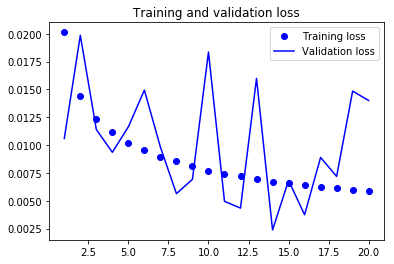

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## make predictions

In [21]:
test_x, test_y = next(test_gen)
test_prediction = model.predict(test_x, 1, verbose=True)
test_predict = scaler.inverse_transform(test_prediction)
true = scaler.inverse_transform(test_y)
for t,p in zip(true, test_predict):
    print(t,p)

16/16 [==============================] - 0s 10ms/step
[5829.] [5827.945]
[5830.] [5828.9355]
[5831.] [5829.927]
[5832.] [5830.918]
[5833.] [5831.91]
[5834.] [5832.9033]
[5835.] [5833.896]
[5836.] [5834.8896]
[5837.] [5835.8843]
[5838.] [5836.879]
[5839.] [5837.8745]
[5840.] [5838.8706]
[5841.] [5839.8677]
[5842.] [5840.865]
[5843.] [5841.8633]
[5844.] [5842.8623]
